In [1]:
import os
import random
import numpy as np
import torch
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
seed_everything(42)

item_df = pd.read_csv("./data/articles.csv")

# fclip = FashionCLIP('fashion-clip')

In [2]:
original_img_path = "./data/images"
original_img_path_withid = [os.path.join(original_img_path, id) for id in os.listdir(original_img_path)]
original_img_path_withid = [[os.path.join(target_path, p) for p in os.listdir(target_path)] for target_path in original_img_path_withid]

In [3]:
original_img_path_withid = [
    p_1
    for p in original_img_path_withid
    for p_1 in p
]

In [4]:
len(original_img_path_withid)

105100

In [5]:
# gen_data_path = "../dataset_fashion/images"
# os.listdir(gen_data_path)

In [6]:
# image_embeddings = fclip.encode_images(original_img_path_withid, batch_size=16)

In [7]:
# with open('original_emb.npy', 'wb') as f:
#     np.save(f, image_embeddings)

In [8]:
with open('original_emb.npy', 'rb') as f:
    image_embeddings = np.load(f)

In [9]:
print(len(original_img_path_withid))
print(image_embeddings.shape)

105100
(105100, 512)


In [10]:
for a, b in zip(original_img_path_withid[:-1], original_img_path_withid[1:]):
    if a > b:
        print("not sorted")
        break

In [11]:
embedding_list = os.listdir("../dataset_fashion/embeddings")

In [12]:
from tqdm import tqdm

gen_ids = [id[:-4] for id in embedding_list]
original_ids = [id[-13:-4] for id in original_img_path_withid]
indices = []
gen_ids_hasimg = []

for id in tqdm(gen_ids):
    try:
        indices.append(original_ids.index(id))
        gen_ids_hasimg.append(id)
    except ValueError:
        pass

  0%|          | 0/62898 [00:00<?, ?it/s]

100%|██████████| 62898/62898 [00:41<00:00, 1499.86it/s]


In [13]:
image_embeddings[indices].shape

(62732, 512)

In [14]:
len(gen_ids_hasimg)

62732

In [15]:
available_items = item_df[item_df["article_id"].isin([int(id) for id in gen_ids_hasimg])]
available_items["detail_desc"] = available_items["detail_desc"].fillna("blank")
prompt_list = available_items["detail_desc"]
prompt_list = prompt_list.tolist()

C:\Users\lijm1\AppData\Local\Temp\ipykernel_7052\3138366550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  available_items["detail_desc"] = available_items["detail_desc"].fillna("blank")


In [16]:
fclip = FashionCLIP('fashion-clip')

In [17]:
text_embeddings = fclip.encode_text(text=prompt_list, batch_size=256)

Map:   0%|          | 0/62732 [00:00<?, ? examples/s]

246it [00:33,  7.28it/s]                         


In [18]:
gen_embedding_paths = [os.path.join("../dataset_fashion/embeddings", id+".pth") for id in gen_ids_hasimg]

In [19]:
gen_embeddings = []
for path in tqdm(gen_embedding_paths):
    gen_embeddings.append(torch.load(path))

100%|██████████| 62732/62732 [04:26<00:00, 235.38it/s] 


In [20]:
gen_embeddings_tensor = np.array(gen_embeddings)
gen_embeddings_tensor = torch.tensor(gen_embeddings_tensor).half().to("cuda")

gen_embeddings_1 = gen_embeddings_tensor[:, 0, :]
gen_embeddings_2 = gen_embeddings_tensor[:, 1, :]
gen_embeddings_3 = gen_embeddings_tensor[:, 2, :]

In [21]:
original_embedding_tensor = torch.tensor(image_embeddings[indices]).half().to("cuda")

In [22]:
text_embeddings_tensor = torch.tensor(text_embeddings).half().to("cuda")

In [23]:
original_embedding_tensor.shape # 원본 이미지 embedding

torch.Size([62732, 512])

In [24]:
gen_embeddings_1.shape  # 생성 이미지 embedding
gen_embeddings_2.shape
gen_embeddings_3.shape

torch.Size([62732, 512])

In [25]:
text_embeddings_tensor.shape    # 텍스트 embedding

torch.Size([62732, 512])

In [26]:
# target item ids
print(len(gen_ids_hasimg))
print(gen_ids_hasimg[:5])

62732
['108775015', '108775044', '108775051', '110065001', '110065002']


mean : 0.59130859375, std : 0.0819091796875


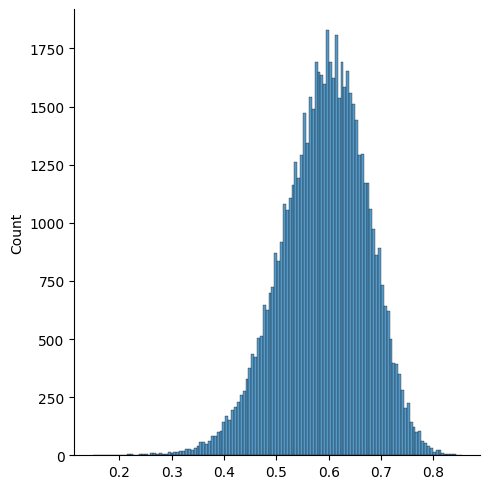

In [27]:
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
import seaborn as sns

cos_img_gen = CosineSimilarity(dim=1)(original_embedding_tensor, gen_embeddings_1)
print(f"mean : {torch.mean(cos_img_gen)}, std : {torch.std(cos_img_gen)}")
sns.displot(cos_img_gen.cpu())

mean : 0.32958984375, std : 0.0308074951171875


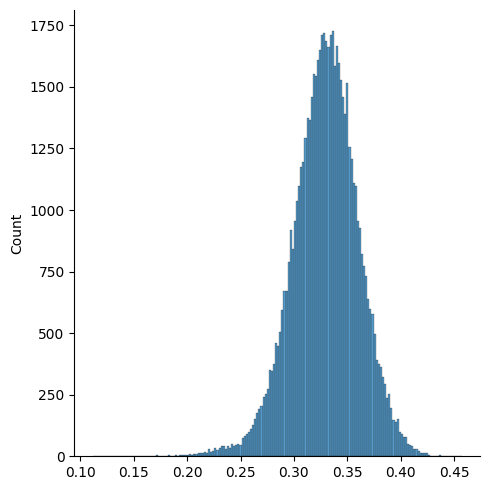

In [28]:
cos_txt_gen = CosineSimilarity(dim=1)(text_embeddings_tensor, gen_embeddings_1)
print(f"mean : {torch.mean(cos_txt_gen)}, std : {torch.std(cos_txt_gen)}")
sns.displot(cos_txt_gen.cpu())

mean : 0.329833984375, std : 0.034454345703125


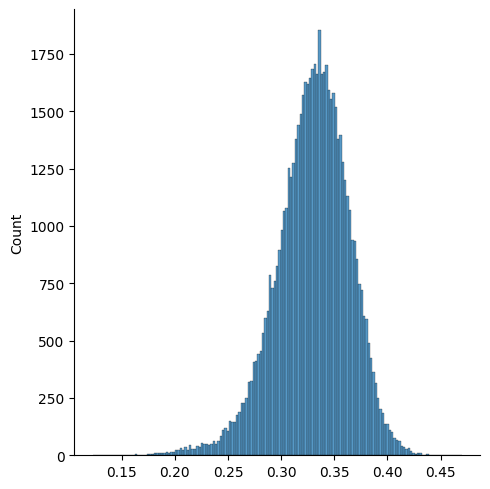

In [29]:
cos_img_txt = CosineSimilarity(dim=1)(original_embedding_tensor, text_embeddings_tensor)
print(f"mean : {torch.mean(cos_img_txt)}, std : {torch.std(cos_img_txt)}")
sns.displot(cos_img_txt.cpu())

C:\Users\lijm1\AppData\Local\Temp\ipykernel_7052\797446436.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cos_img_gen.cpu(), hist=False, label="image-genimg")
C:\Users\lijm1\AppData\Local\Temp\ipykernel_7052\797446436.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cos

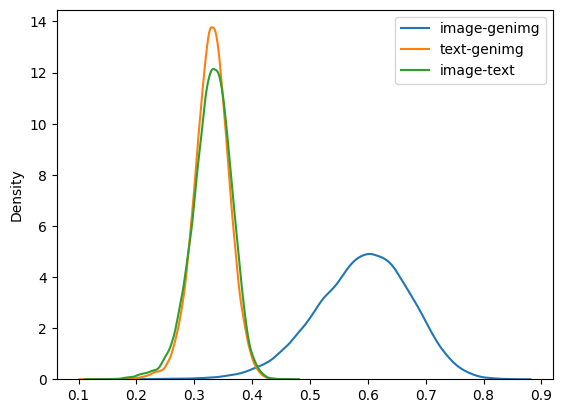

In [30]:
sns.distplot(cos_img_gen.cpu(), hist=False, label="image-genimg")
sns.distplot(cos_txt_gen.cpu(), hist=False, label="text-genimg")
sns.distplot(cos_img_txt.cpu(), hist=False, label="image-text")
plt.legend()
plt.show()

----------

In [31]:
item_df[["prod_name", "product_type_name", "product_group_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]]

,prod_name,product_type_name,product_group_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,Strap top,Vest top,Garment Upper body,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,Strap top,Vest top,Garment Upper body,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,Strap top (1),Vest top,Garment Upper body,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,OP T-shirt (Idro),Bra,Underwear,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,OP T-shirt (Idro),Bra,Underwear,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
...,...,...,...,...,...,...,...,...
105537,5pk regular Placement1,Socks,Socks & Tights,Socks Bin,Menswear,Menswear,Men Underwear,Socks and Tights
105538,SPORT Malaga tank,Vest top,Garment Upper body,Jersey,Ladieswear,Ladieswear,H&M+,Jersey Fancy
105539,Cartwheel dress,Dress,Garment Full body,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy
105540,CLAIRE HAIR CLAW,Hair clip,Accessories,Small Accessories,Divided,Divided,Divided Accessories,Accessories


In [32]:
def erase_random_word(text):
    text_list = text.split()
    text_list_erased = [word if np.random.random() > 0.3 else '' for word in text_list]
    text_erased = " ".join(text_list_erased)
    text_erased = " ".join(text_erased.split()) # remove long blank
    text_erased += "." if len(text_erased) > 1 and text_erased[-1] != "." else ""
    
    return text_erased

In [190]:
prompt_list_erased = available_items["detail_desc"].apply(erase_random_word)
prompt_list_erased = prompt_list_erased + " " + available_items["product_type_name"]

In [198]:
available_items.groupby("detail_desc")["detail_desc"].count().sort_values()

detail_desc
14 pairs of metal earrings in various sizes and designs.                                                                                                                       1
Knee-length, pleated skirt in a jacquard weave with a high waist and sewn-in wrapover at the front with an asymmetric hem. Concealed zip and button in one side. Unlined.      1
Short-sleeved dress in patterned cotton jersey with a gathered seam at the hips and a flared skirt.                                                                            1
Knee-length, pleated skirt in woven fabric with a sheen. Regular waist with covered elastication and a drawstring with narrow ties, and an overlocked hem. Unlined.            1
Knee-length, pleated skirt in woven fabric with an overlocked hem. Regular waist with covered elastication. Unlined.                                                           1
                                                                                                       

In [34]:
items_sameprompt = available_items[available_items["detail_desc"] == "Socks in a soft, jacquard-knit cotton blend with elasticated tops."]

In [37]:
items_sameprompt_erased = items_sameprompt["detail_desc"].apply(erase_random_word)
items_sameprompt_erased = items_sameprompt_erased + " " + items_sameprompt["product_type_name"]

In [40]:
# items_sameprompt_erased.to_csv("./data/same_prompt_erased.csv")

In [41]:
items_sameprompt_erased

65684          jacquard-knit cotton blend with tops. Socks
76049    Socks a soft, jacquard-knit cotton blend elast...
76050             Socks in a soft, elasticated tops. Socks
76051    in a soft, jacquard-knit blend with elasticate...
76052         Socks soft, jacquard-knit cotton with. Socks
                               ...                        
82080    Socks in soft, cotton blend with elasticated t...
82081    Socks in soft, jacquard-knit cotton blend with...
90402           soft, jacquard-knit blend with tops. Socks
90403    Socks in a soft, jacquard-knit cotton blend el...
90404        a soft, jacquard-knit cotton with tops. Socks
Length: 107, dtype: object

In [42]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from transformers import CLIPModel, CLIPProcessor

In [43]:
clip_model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    custom_pipeline="clip_guided_stable_diffusion",
    torch_dtype = torch.float16,
    clip_model = clip_model,
    use_safetensors=True,
    safety_checker = None,
    requires_safety_checker = False,
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

c:\Users\lijm1\miniconda3\envs\mlenv\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lijm1\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\lijm1\miniconda3\envs\mlenv\lib\site-packages\huggingface_hub\file_download.py:67

(…)ommunity/clip_guided_stable_diffusion.py:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Keyword arguments {'safety_checker': None, 'requires_safety_checker': False} are not expected by CLIPGuidedStableDiffusion and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [44]:
pipe = pipe.to("cuda")

In [49]:
items_sameprompt_erased

65684          jacquard-knit cotton blend with tops. Socks
76049    Socks a soft, jacquard-knit cotton blend elast...
76050             Socks in a soft, elasticated tops. Socks
76051    in a soft, jacquard-knit blend with elasticate...
76052         Socks soft, jacquard-knit cotton with. Socks
                               ...                        
82080    Socks in soft, cotton blend with elasticated t...
82081    Socks in soft, jacquard-knit cotton blend with...
90402           soft, jacquard-knit blend with tops. Socks
90403    Socks in a soft, jacquard-knit cotton blend el...
90404        a soft, jacquard-knit cotton with tops. Socks
Length: 107, dtype: object

In [51]:
for item in items_sameprompt_erased.items():
    print(item)
    break

(65684, 'jacquard-knit cotton blend with tops. Socks')


In [52]:
for i, (idx, prompt) in enumerate(items_sameprompt_erased.items()):
    images = pipe(prompt, width=512, height=512, num_inference_steps=30)[0]
    images[0].save(os.path.join("../dataset_fashion/gen_socks_sameprompt", f"{idx}.jpg"))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [71]:
original_ids = available_items.loc[items_sameprompt_erased.index]["article_id"]
original_img_path = [f"./data/images/{'0'+str(ids)[:2]}/{'0'+str(ids)+'.jpg'}" for ids in original_ids]
gen_img_path = [os.path.join("../dataset_fashion/gen_socks_sameprompt", f"{idx}.jpg") for idx in items_sameprompt_erased.index]
gen_img_prompt = items_sameprompt_erased.values

In [73]:
def erased_prompt_image_generator():
    yield from zip(original_img_path, gen_img_path, gen_img_prompt)

In [74]:
gen = erased_prompt_image_generator()

In [75]:
for orig_path, gen_path, prompt in gen:
    print(orig_path)
    print(gen_path)
    print(prompt)

./data/images/074/0745256007.jpg
../dataset_fashion/gen_socks_sameprompt\65684.jpg
jacquard-knit cotton blend with tops. Socks
./data/images/078/0783707002.jpg
../dataset_fashion/gen_socks_sameprompt\76049.jpg
Socks a soft, jacquard-knit cotton blend elasticated. Socks
./data/images/078/0783707004.jpg
../dataset_fashion/gen_socks_sameprompt\76050.jpg
Socks in a soft, elasticated tops. Socks
./data/images/078/0783707005.jpg
../dataset_fashion/gen_socks_sameprompt\76051.jpg
in a soft, jacquard-knit blend with elasticated. Socks
./data/images/078/0783707012.jpg
../dataset_fashion/gen_socks_sameprompt\76052.jpg
Socks soft, jacquard-knit cotton with. Socks
./data/images/078/0783707015.jpg
../dataset_fashion/gen_socks_sameprompt\76053.jpg
Socks in a soft, jacquard-knit cotton with elasticated. Socks
./data/images/078/0783707019.jpg
../dataset_fashion/gen_socks_sameprompt\76054.jpg
Socks in jacquard-knit blend with elasticated tops. Socks
./data/images/078/0783707021.jpg
../dataset_fashion/ge

In [66]:
original_img_path

['./data/images/074/0745256007.jpg',
 './data/images/078/0783707002.jpg',
 './data/images/078/0783707004.jpg',
 './data/images/078/0783707005.jpg',
 './data/images/078/0783707012.jpg',
 './data/images/078/0783707015.jpg',
 './data/images/078/0783707019.jpg',
 './data/images/078/0783707021.jpg',
 './data/images/078/0783707026.jpg',
 './data/images/078/0783707028.jpg',
 './data/images/078/0783707029.jpg',
 './data/images/078/0783707030.jpg',
 './data/images/078/0783707031.jpg',
 './data/images/078/0783707032.jpg',
 './data/images/078/0783707033.jpg',
 './data/images/078/0783707034.jpg',
 './data/images/078/0783707036.jpg',
 './data/images/078/0783707037.jpg',
 './data/images/078/0783707038.jpg',
 './data/images/078/0783707039.jpg',
 './data/images/078/0783707041.jpg',
 './data/images/078/0783707043.jpg',
 './data/images/078/0783707045.jpg',
 './data/images/078/0783707046.jpg',
 './data/images/078/0783707047.jpg',
 './data/images/078/0783707048.jpg',
 './data/images/078/0783707049.jpg',
 

----------

In [21]:
A_norm = original_embedding_tensor / torch.norm(original_embedding_tensor, dim=1, keepdim=True)
B_norm = gen_embeddings_1 / torch.norm(gen_embeddings_1, dim=1, keepdim=True)

cosine_similarity_matrix = torch.mm(B_norm, A_norm.t())
index_most_sim = cosine_similarity_matrix.argmax(dim=1)

In [22]:
sim_argsort = []
for i, row in enumerate(tqdm(cosine_similarity_matrix)):
    sim_argsort.append(row.argsort(descending=True)[:40].type(torch.int32))
    if i%1000 == 1:
        torch.cuda.empty_cache()

100%|██████████| 62732/62732 [00:05<00:00, 10795.25it/s]


In [23]:
sim_argsort = torch.stack(sim_argsort)

In [24]:
sim_argsort

tensor([[59435, 17975,  6696,  ..., 11642, 23366, 53898],
        [52100,     0, 41886,  ..., 58804,  1380, 24462],
        [62031, 40287, 58303,  ..., 13359, 62694, 30304],
        ...,
        [20521, 20032, 22029,  ..., 62717, 23301, 44135],
        [53021, 31547,  8912,  ...,  8918,  4398,  7182],
        [ 6525, 60975, 51949,  ..., 58397, 61103, 50144]], device='cuda:0',
       dtype=torch.int32)

In [25]:
in_40 = []
for i in range(sim_argsort.size()[0]):
    in_40.append(i in sim_argsort[i])

In [60]:
sum(in_40) / len(in_40)

0.2113913154370975

In [26]:
target_idx = 1890 # generated image index
# target_idx = 1
target_emb_indices = sim_argsort[target_idx][:10]
target_img_ids = np.array(gen_ids_hasimg)[target_emb_indices.cpu().numpy()]
query_img_id = gen_ids_hasimg[target_idx]

In [27]:
target_img_ids

array(['554011001', '566941012', '554011005', '685604045', '685604050',
       '554011011', '453309008', '566942004', '453453020', '581859006'],
      dtype='<U9')

In [28]:
target_img_id, query_img_id

NameError: name 'target_img_id' is not defined

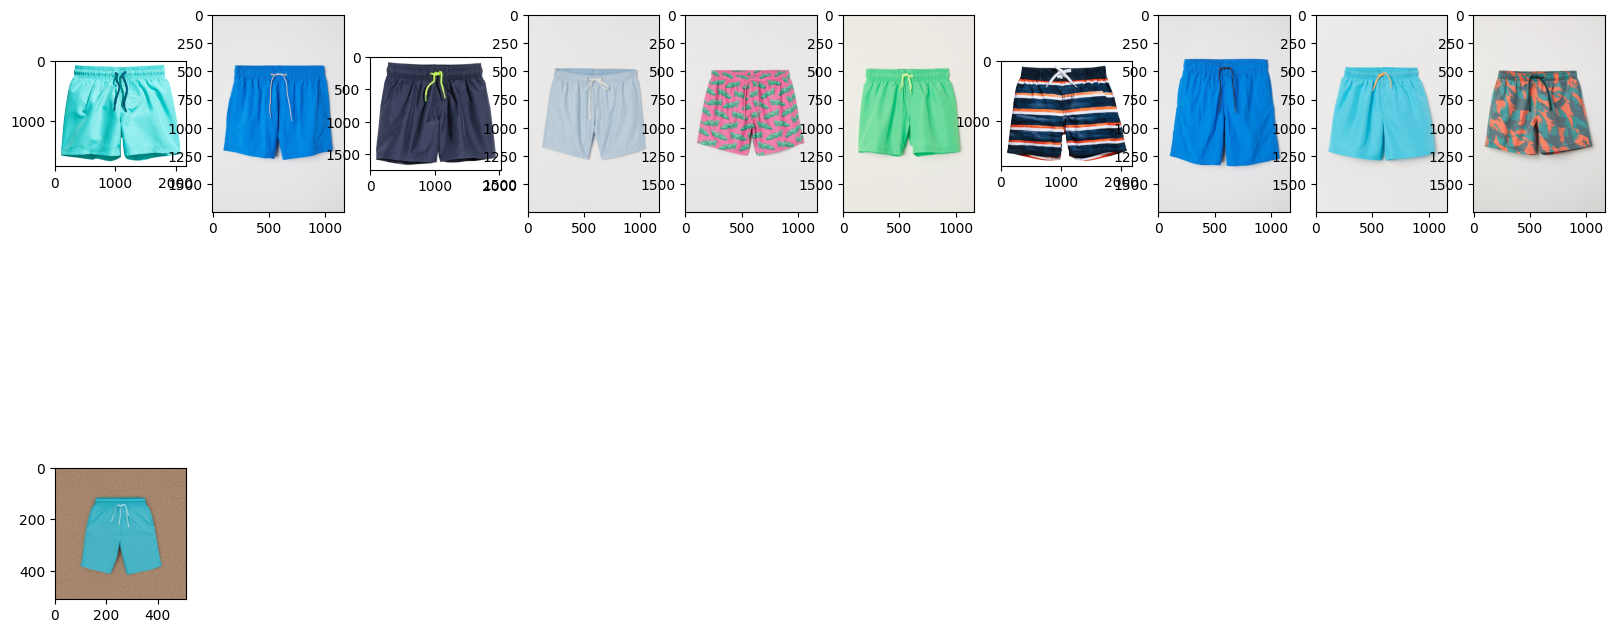

In [29]:
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for i, target_img_id in enumerate(target_img_ids):
    plt.subplot(2, 10, i+1)
    plt.imshow(Image.open(f"./data/images/{'0'+target_img_id[:2]}/{'0'+target_img_id+'.jpg'}"))
plt.subplot(2, 10, len(target_img_ids)+1)
plt.imshow(Image.open(f"../dataset_fashion/images/{query_img_id}/{query_img_id+'_0.jpg'}"))
plt.show()

--------------